In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read all dataframe from 9geek website.
# c = constituency; candi = candidate
pwd = "9geek_dataset/"
info_c9 = pd.read_csv(pwd + "info_constituency9.csv")
info_party9 = pd.read_csv(pwd + "info_party9.csv")
info_province9 = pd.read_csv(pwd + "info_province9.csv")
result_partylist9 = pd.read_csv(pwd + "result_partylist9.csv")
result_cstatus9 = pd.read_csv(pwd + "result_constituency_status9.csv")
result_candi9 = pd.read_csv(pwd + "result_candidate9.csv")

# Read my personal dataframe
info_province = pd.read_csv("PL_info_province.csv")
result_candi = pd.read_csv("PL_result_constituencies_CandidateConst.csv")
result_overall = pd.read_csv("PL_result_constituencies_Overall.csv").rename(columns = {"Unnamed: 0":"cons_id"})
result_overall = result_overall.drop(columns = result_overall.columns.tolist()[4:]).set_index("cons_id")

In [25]:
# Create a map between party ID, color, and name
id_name = dict(zip(info_party9["id"], info_party9["name"]))
party_color_map = dict(zip(info_party9["id"], info_party9["color"]))

# Ideology standpoint

Thai election is often viewed through binary lens — progressive versus conservative; pro-democracy versus pro-authoritarian; etc. My favorite quote says, "lens helps clarify but also distorts." Although prefer not to view election according to such a binary lens (how would you define authoritarian anyway?), I will proceed with the analysis using the term.

# Results

## Margin of victory per ideological camp

Is there a collusion between parties from the same ideological camp? What's the margin of victory of each party across constituents with different ideological leanings?

In [4]:
# The mp_app_vote is not properly ordered in the modified dataset. Hence, I re-arranged the mp_app_rank.
result_candi = result_candi.sort_values(by = ["cons_id", "mp_app_vote"],ascending=False)
result_candi["mp_app_rank"] = result_candi.groupby("cons_id")["mp_app_vote"].rank(method="dense",ascending=False)
# Recalculate the percent each candidate obtains
result_candi["percent"] = result_candi["mp_app_vote"].div(result_candi.groupby("cons_id")["mp_app_vote"].transform(lambda x: x.sum()/100))
# Choose 3 decimals because assuming 100,000 voters per constituency, 0.001% = 1 voter. 
result_candi["percent"] = np.around(result_candi["percent"],decimals = 3)

# Check results
result_candi

,cons_id,mp_app_id,mp_app_rank,mp_app_vote,percent,party_id
4770,YST_3,YST_3_5,1.0,38074,37.961,709
4771,YST_3,YST_3_2,2.0,25205,25.130,705
4772,YST_3,YST_3_9,3.0,14564,14.521,726
4773,YST_3,YST_3_10,4.0,13622,13.582,707
4774,YST_3,YST_3_4,5.0,4963,4.948,743
...,...,...,...,...,...,...
8,ACR_1,ACR_1_1,9.0,459,0.455,706
9,ACR_1,ACR_1_2,10.0,234,0.232,769
10,ACR_1,ACR_1_13,11.0,212,0.210,761
11,ACR_1,ACR_1_12,12.0,127,0.126,742


In [5]:
# Create a map from each party to its ideological camp
cons_lst = [701, 706, 707, 709, 743, 763] # Democrat, Chatpattana Kla, Chatthaipattana, Bhumjaithai, PPRP, RTSC
prog_lst = [705,726,762,719,740,773] # Pheu Thai, MFP, Thai Sang Thai, Seri, Prachachat, Pheu Thai Ruam Palang
leaning_map = {id: "conservative" for id in cons_lst}
leaning_map.update({id: "progressive" for id in prog_lst})


# Summarize the leaning of each candidate in the constituency result
result_candi["leaning"] = result_candi["party_id"].map(leaning_map)

In [6]:
# Double-check constituency results
## 1. Do I have the right number of winners?
temp = result_candi[result_candi["mp_app_rank"] == 1]["party_id"].value_counts().to_frame()
temp["party_name"] = temp.index.map(id_name)
temp["leaning"] = temp.index.map(leaning_map)

## 2. Do I have the right number of constituency MP? 
## Result should give 162 conservatives and 238 progressives. 
result_candi[result_candi["mp_app_rank"] == 1]["leaning"].value_counts()

leaning
progressive     238
conservative    162
Name: count, dtype: int64

In [19]:
# Create a new dataframe that summarizes the victory pattern for each candidate constituency
victory_df = pd.DataFrame(index = result_candi["cons_id"].unique(), 
                          columns = ["winner_id", "winner_name","winner_leaning","margin"]) 

In [20]:
# Fill in the information about winners
victory_df["winner_id"] = result_candi.groupby("cons_id").nth(0)["party_id"].to_numpy()
victory_df["winner_name"] = victory_df["winner_id"].map(id_name)
victory_df["winner_leaning"] = victory_df["winner_id"].map(leaning_map)

# Fill in the margin of victory (difference in percent between the first and the second)
temp = result_candi.groupby("cons_id")
victory_df["margin"] = temp.nth(0)["percent"].to_numpy() - temp.nth(1)["percent"].to_numpy()

# Fill in the ideological leaning (defined as the percent of voters for parties in each ideological camp) per constituency
victory_df

,winner_id,winner_name,winner_leaning,margin
YST_3,709,ภูมิใจไทย,conservative,12.831
YST_2,705,เพื่อไทย,progressive,10.878
YST_1,762,ไทยสร้างไทย,progressive,26.263
YLA_3,740,ประชาชาติ,progressive,7.542
YLA_2,740,ประชาชาติ,progressive,29.282
...,...,...,...,...
AYA_1,726,ก้าวไกล,progressive,5.257
ATG_2,709,ภูมิใจไทย,conservative,29.968
ATG_1,709,ภูมิใจไทย,conservative,28.246
ACR_2,709,ภูมิใจไทย,conservative,25.908


In [21]:
# If we categorize parties into two groups — conservative and progressive — and believe candidate constituency voters
# do not switch camp, we can see the degree of collusion between them.
temp = result_candi.groupby(["cons_id", "leaning"]).sum().reset_index()
temp = temp[temp["leaning"] == "progressive"]
temp = temp.set_index("cons_id")

# Create a dataframe of progressive percent per constituency
const_leaning = pd.DataFrame(index = temp.index.tolist(), columns = ["progressive_percent"])
const_leaning["progressive_percent"] = temp["percent"]
victory_df = victory_df.join(const_leaning)

In [46]:
# Because matplotlib does not support Thai, I need to encode each party's name in English.
id_name[701] = "Democrat"
id_name[707] = "Chart Thai Pattana"
id_name[706] = "Chart Pattana Kla"
id_name[709] = "Bhumjaithai"
id_name[743] = "PPRP"
id_name[763] = "Ruam Thai Sang Chart"
id_name[705] = "Pheu Thai"
id_name[726] = "Move Forward"
id_name[762] = "Thai Sang Thai"
id_name[740] = "Prachachart"
id_name[719] = "Seri Ruam Thai"
id_name[769] = "Thai Pakdee"
id_name[773] = "Pheu Thai Ruampalang"

Text(0.5, 1.0, 'Scatterplot of margin of victory across constituency')

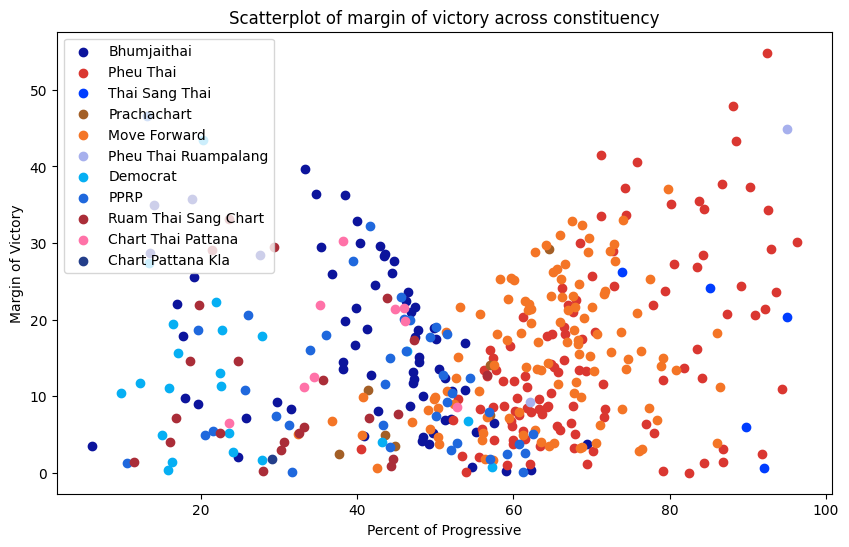

In [53]:
victory_df["winner_color"] = victory_df["winner_id"].map(party_color_map)
ax = plt.subplots(figsize = (10,6))
for winner_id in victory_df["winner_id"].unique():
    temp = victory_df[victory_df["winner_id"] == winner_id]  
    plt.scatter(temp["progressive_percent"], temp["margin"], c = party_color_map[winner_id], label=id_name[winner_id])
plt.xlabel("Percent of Progressive")
plt.ylabel("Margin of Victory")
plt.legend()
plt.title("Scatterplot of margin of victory across constituency")

In [42]:
id_name[701] = "Democrat"
id_name[707] = "Chart Thai Pattana"
id_name[706] = "Chart Pattana Kla"
id_name[709] = "Bhumjaithai"
id_name[743] = "PPRP"
id_name[763] = "Ruam Thai Sang Chart"
id_name[705] = "Pheu Thai"
id_name[726] = "Move Forward"
id_name[762] = "Thai Sang Thai"
id_name[740] = "Prachachart"
id_name[719] = "Seri Ruam Thai"
id_name[769] = "Thai Pakdee"

In [43]:
id_name

{701: 'Democrat',
 702: 'ประชากรไทย',
 703: 'ความหวังใหม่',
 705: 'Pheu Thai',
 706: 'Chart Pattana Kla',
 707: 'Chart Thai Pattana',
 708: 'อนาคตไทย',
 709: 'Bhumjaithai',
 710: 'สังคมประชาธิปไตยไทย',
 711: 'ประชาสามัคคี',
 712: 'ประชาธิปไตยใหม่',
 713: 'พลังบูรพา',
 714: 'ครูไทยเพื่อประชาชน',
 715: 'พลังสหกรณ์',
 717: 'ถิ่นกาขาวชาววิไล',
 718: 'รักษ์ผืนป่าประเทศไทย',
 719: 'Seri Ruam Thai',
 720: 'รักษ์ธรรม',
 721: 'เพื่อชาติ',
 722: 'พลังประชาธิปไตย',
 723: 'ภราดรภาพ',
 724: 'พลังไทยรักชาติ',
 725: 'ช่วยชาติ',
 726: 'Move Forward',
 727: 'ทางเลือกใหม่',
 728: 'ประชาภิวัฒน์',
 729: 'เส้นด้าย',
 731: 'พลังธรรมใหม่',
 732: 'ไทยธรรม',
 733: 'ไทยศรีวิไลย์',
 734: 'รวมพลัง',
 736: 'ไทยพร้อม',
 737: 'พลังปวงชนไทย',
 738: 'เพื่อชาติไทย',
 739: 'รวมแผ่นดิน',
 740: 'Prachachart',
 741: 'แผ่นดินธรรม',
 742: 'คลองไทย',
 743: 'PPRP',
 745: 'พลังสังคม',
 747: 'เป็นธรรม',
 748: 'พลังเพื่อไทย',
 749: 'ประชาไทย',
 750: 'กรีน',
 751: 'สามัญชน',
 752: 'ภาคีเครือข่ายไทย',
 755: 'เพื่ออนาคตไทย',
 758: '

In [34]:
victory_df["winner_id"].unique()

array([709, 705, 762, 740, 726, 773, 701, 743, 763, 707, 706])